<a href="https://colab.research.google.com/github/hajsf/Time-Series-Forecast/blob/main/06_ConsumeModel.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Mount google drive

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
import pandas as pd
import glob
import numpy as np

In [3]:
# import required library
import matplotlib.pyplot as plt
import seaborn as sns
import xgboost as xgb
from sklearn.metrics import mean_squared_error
import pickle
from xgboost import plot_importance

**Read the csv files**


*   Define correct seperator, tab in our example
*   Use dtype to enforce data type mainy in casefield field has mix data types
*   Use low_memory=False so you do not mind whatever type the undefined fields are read in they have mix data





In [4]:
path = "/content/drive/MyDrive/ColabNotebooks/dataset/02_ProcessedData/"

**Load Future known features**

In [5]:
data = pd.read_csv(path + 'Future.csv', sep=',', lineterminator='\r', low_memory=False) # , dtype={"DATE1": 'string', "SLS_CNTR_ID": "string", "ITEM_ID": "string"}

In [6]:
data.head()

,DATE1,SLS_CNTR_ID,isSalaryweek,AcademicCalendarSemester,isWeekend,isRamadan,isRamadanEnd,isEid,isNationalday
0,\n8/1/2022,58.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,\n8/2/2022,58.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,\n8/3/2022,58.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,\n8/4/2022,58.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,\n8/5/2022,58.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0


**Clean future data**

In [7]:
data = data.replace('\n','', regex=True)

In [8]:
data.head()

,DATE1,SLS_CNTR_ID,isSalaryweek,AcademicCalendarSemester,isWeekend,isRamadan,isRamadanEnd,isEid,isNationalday
0,8/1/2022,58.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,8/2/2022,58.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,8/3/2022,58.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,8/4/2022,58.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,8/5/2022,58.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0


**Format future data data (dates, string, numbers, ..)**

In [9]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 32 entries, 0 to 31
Data columns (total 9 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   DATE1                     32 non-null     object 
 1   SLS_CNTR_ID               31 non-null     float64
 2   isSalaryweek              31 non-null     float64
 3   AcademicCalendarSemester  31 non-null     float64
 4   isWeekend                 31 non-null     float64
 5   isRamadan                 31 non-null     float64
 6   isRamadanEnd              31 non-null     float64
 7   isEid                     31 non-null     float64
 8   isNationalday             31 non-null     float64
dtypes: float64(8), object(1)
memory usage: 2.4+ KB


In [10]:
data

,DATE1,SLS_CNTR_ID,isSalaryweek,AcademicCalendarSemester,isWeekend,isRamadan,isRamadanEnd,isEid,isNationalday
0,8/1/2022,58.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,8/2/2022,58.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,8/3/2022,58.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,8/4/2022,58.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,8/5/2022,58.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
5,8/6/2022,58.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
6,8/7/2022,58.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
7,8/8/2022,58.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
8,8/9/2022,58.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
9,8/10/2022,58.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


**Drop the row if single column is NAN**

In [11]:
data = data.dropna() #data.dropna(subset=['SLS_CNTR_ID']) 

In [12]:
data

,DATE1,SLS_CNTR_ID,isSalaryweek,AcademicCalendarSemester,isWeekend,isRamadan,isRamadanEnd,isEid,isNationalday
0,8/1/2022,58.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,8/2/2022,58.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,8/3/2022,58.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,8/4/2022,58.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,8/5/2022,58.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
5,8/6/2022,58.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
6,8/7/2022,58.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
7,8/8/2022,58.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
8,8/9/2022,58.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
9,8/10/2022,58.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [ ]:
data['DATE1'] = pd.to_datetime(data['DATE1'], format='%m/%d/%Y') #  %H:%M:%S

In [15]:
data = data.sort_values('DATE1')

RoundUp and RoundDown functions

In [16]:
from math import floor, ceil

def roundDown(n, d=8):
    d = int('1' + ('0' * d))
    return floor(n * d) / d

def roundUp(n, d=8):
    d = int('1' + ('0' * d))
    return ceil(n * d) / d

In [17]:
roundDown(3.2, 0)

3.0

In [21]:
data.set_index("DATE1", inplace = True)

In [ ]:
#data = data.drop(columns=['DATE1'])

**Load Model**

In [18]:
with open(path + 'model.pk', 'rb') as f:
  model = pickle.load(f)
print("model:", model)

model: XGBRegressor(base_score=0.05, early_stopping_rounds=50, learning_rate=0.001,
             missing=nan, n_estimators=1000, objective='reg:squarederror',
             random_state=5)


**Make detection**

In [27]:
data = data.drop(columns=['ForecastedQty'])

In [28]:
data['ForecastedQty'] = model.predict(data)

In [24]:
data['ForecastedQty'] = round(data['ForecastedQty'], 0) # or use floor() or ceil()

In [29]:
data

,SLS_CNTR_ID,isSalaryweek,AcademicCalendarSemester,isWeekend,isRamadan,isRamadanEnd,isEid,isNationalday,ForecastedQty
DATE1,,,,,,,,,
2022-08-01,58.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,5.962841
2022-08-02,58.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,5.962841
2022-08-03,58.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,5.962841
2022-08-04,58.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,5.962841
2022-08-05,58.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,5.962841
2022-08-06,58.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,5.962841
2022-08-07,58.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,5.962841
2022-08-08,58.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,5.962841
2022-08-09,58.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,5.962841


In [ ]:
#data = data.reset_index()

Toal forecasted quantity = 186.87793


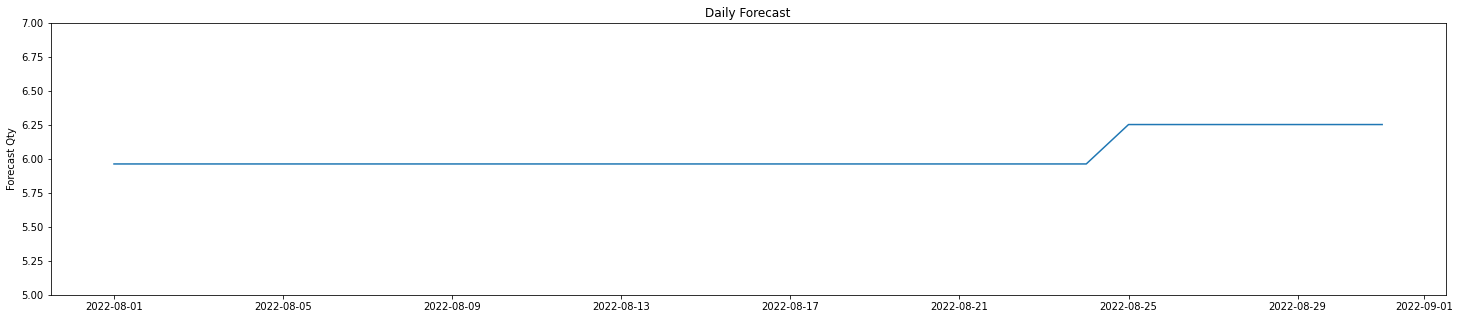

In [31]:
import matplotlib.pyplot as plt
fig, ax = plt.subplots(figsize=(25, 5))
plt.plot(data.index.get_level_values('DATE1'), data['ForecastedQty'])
plt.ylabel('Forecast Qty')

plt.ylim([5, 7]) #ymax is your value
# or as below (same applicable for xlim):
#plt.ylim(bottom=5) #ymin is your value
#plt.ylim(top=7) #ymax is your value
print('Toal forecasted quantity =', data['ForecastedQty'].sum())

plt.title("Daily Forecast")
plt.show()

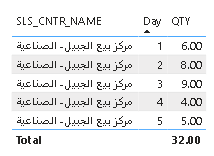